### SIDM with pyHalo

This notebook demonstrates how to generate realizations of self-interacting dark matter. The functionality demonstrated in this notebook is different from that presented in the self_interacting_dark_matter notebook: Here, we specify the cross section strength in different mass bins, and halos evolve according to the parametric model presented by Yang et al. (2022). 

In [1]:
from pyHalo.realization_extensions import RealizationExtensions
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from pyHalo.PresetModels.cdm import CDM
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from lenstronomy.LensModel.lens_model import LensModel

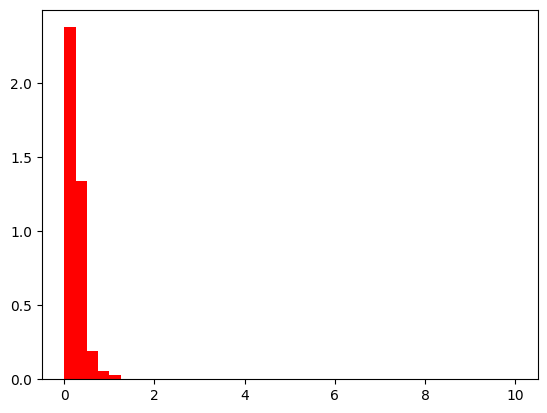

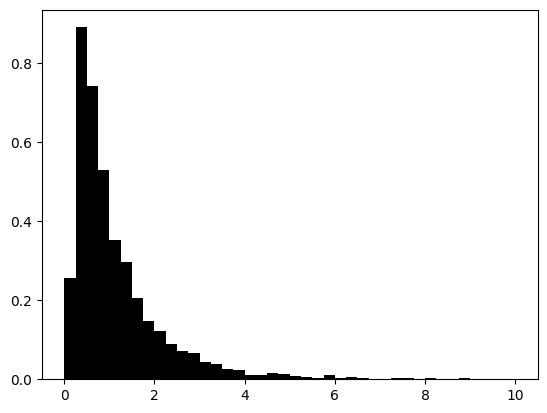

(array([0.00216411, 0.05554554, 0.20342651, 0.28061317, 0.31018936,
        0.30297565, 0.27628494, 0.24382326, 0.22867448, 0.18611362,
        0.20198377, 0.16807935, 0.15004509, 0.13345356, 0.10676285,
        0.1103697 , 0.10459874, 0.09738503, 0.07790803, 0.07646528,
        0.06708747, 0.06059513, 0.06275924, 0.0541028 , 0.03029757,
        0.04688909, 0.03823264, 0.03751127, 0.03390442, 0.03029757,
        0.02669071, 0.03174031, 0.02236249, 0.02308386, 0.02019838,
        0.02164112, 0.02308386, 0.01947701, 0.01587015, 0.01731289]),
 array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
         2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
         4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
         6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,
         9.  ,  9.25,  9.5 ,  9.75, 10.  ]),
 <BarContainer object of 40 artists>)

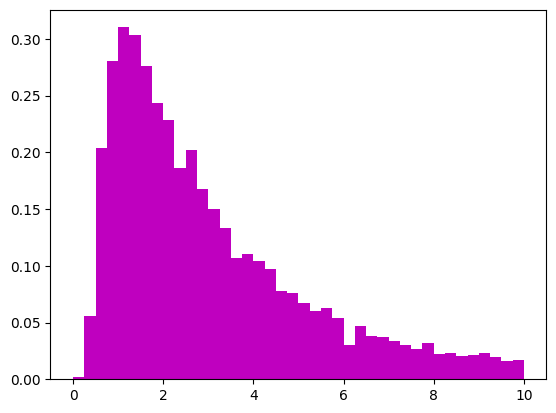

In [2]:
zlens, zsource = 0.5, 2.0
mass_ranges = [[6.0, 7.5], [7.5, 8.5], [8.5, 10.0]]

cdm_realization = CDM(zlens, zsource)
ext = RealizationExtensions(cdm_realization)

# halos can be made to collapse faster or slower through the log10_subhalo_time_scaling parameter
log10_subhalo_time_scaling = 0.0
sigma_eff = [0, 0, 0.0]
cdm_realization0 = ext.toSIDM_from_cross_section(mass_ranges, sigma_eff, log10_subhalo_time_scaling)

sigma_eff = [1.5,1.5,1.5]
sidm_realization1 = ext.toSIDM_from_cross_section(mass_ranges, sigma_eff, log10_subhalo_time_scaling)

sigma_eff = [2.5,2.5,2.5]
sidm_realization2 = ext.toSIDM_from_cross_section(mass_ranges, sigma_eff, log10_subhalo_time_scaling)

sigma_eff = [3.,3.,3.]
sidm_realization3 = ext.toSIDM_from_cross_section(mass_ranges, sigma_eff, log10_subhalo_time_scaling)

t = []
for halo in sidm_realization1.halos:
    if halo.mdef == 'TNFW': continue
    t.append(halo.t_over_tc)
plt.hist(t, color='r',density=True, bins=40,range=(0, 10))
plt.show()
t = []
for halo in sidm_realization2.halos:
    if halo.mdef == 'TNFW': continue
    t.append(halo.t_over_tc)
plt.hist(t, color='k',density=True, bins=40,range=(0, 10))
plt.show()
t = []
for halo in sidm_realization3.halos:
    if halo.mdef == 'TNFW': continue
    t.append(halo.t_over_tc)
plt.hist(t, color='m',density=True, bins=40,range=(0, 10))

### Now we can compute the effective multiplane convergence with SIDM halos

In [3]:
npix = 150 
grid_resolution_critcurves = 0.04
grid_size = 1.5
_x = _y = np.linspace(-grid_size, grid_size, npix)
xx, yy = np.meshgrid(_x, _y)
shape0 = xx.shape

# power law plus shear macromodel
kwargs_macromodel = [{'theta_E': 1., 'center_x': 0., 'center_y': 0., 'e1': 0.2, 'e2': -0.1, 'gamma': 2.},
                    {'gamma1': -0.03, 'gamma2': 0.02}]
lens_model_list_macro = ['EPL', 'SHEAR']
lens_model_macro = LensModel(lens_model_list_macro)

residual_kappa_map_list = []
ra_crit_list_list = []
dec_crit_list_list = []

for sidm_realization in [cdm_realization0, sidm_realization1, sidm_realization2, sidm_realization3]:
    print(sidm_realization)
    
    lens_model_list, lens_redshift_array, kwargs_halos, _ = sidm_realization.lensing_quantities()

    astropy_instance = sidm_realization.astropy_instance

    lens_model_list_full = lens_model_list_macro + lens_model_list
    lens_redshift_list_full = [zlens, zlens] + list(lens_redshift_array)
    kwargs_lens_full = kwargs_macromodel + kwargs_halos

    lens_model_full = LensModel(lens_model_list_full, zlens, zsource, 
                            lens_redshift_list_full, cosmo=astropy_instance, multi_plane=True)


    kappa_full = lens_model_full.kappa(xx.ravel(), yy.ravel(), kwargs_lens_full).reshape(shape0)
    kappa_macro = lens_model_macro.kappa(xx.ravel(), yy.ravel(), kwargs_macromodel).reshape(shape0)
    residual_kappa_map_list.append(kappa_full - kappa_macro)

    lens_model_extension = LensModelExtensions(lens_model_full)
    
    ra_crit_list, dec_crit_list, _, _ = lens_model_extension.critical_curve_caustics(kwargs_lens_full, 
                                                                compute_window=2*grid_size, 
                                                                grid_scale=grid_resolution_critcurves)
    ra_crit_list_list.append(ra_crit_list)
    dec_crit_list_list.append(dec_crit_list)


### Make the figure

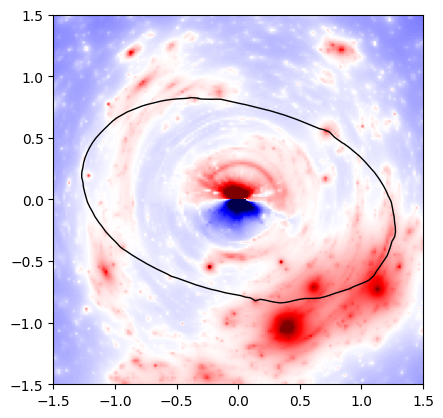

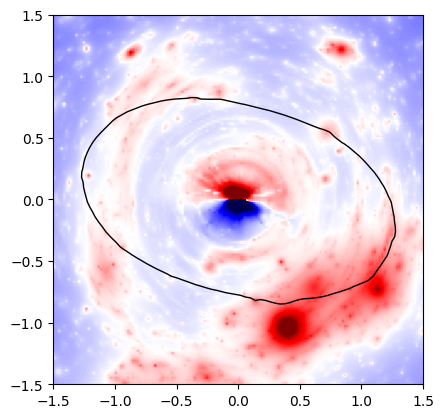

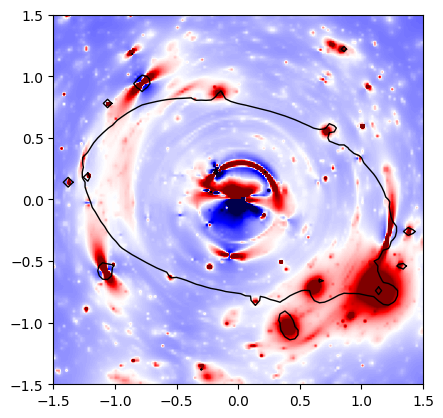

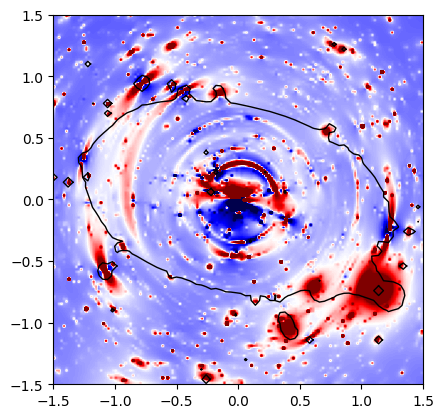

In [4]:
for (kap, rac, dec) in zip(residual_kappa_map_list, ra_crit_list_list, dec_crit_list_list):
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.imshow(kap- np.mean(kap), vmin=-0.1, vmax=0.1, cmap='seismic',
             extent=[-grid_size, grid_size, -grid_size, grid_size], origin='lower')
    for i in range(0, len(rac)):
        ax.plot(rac[i], dec[i], color='k', lw=1)
    plt.show()

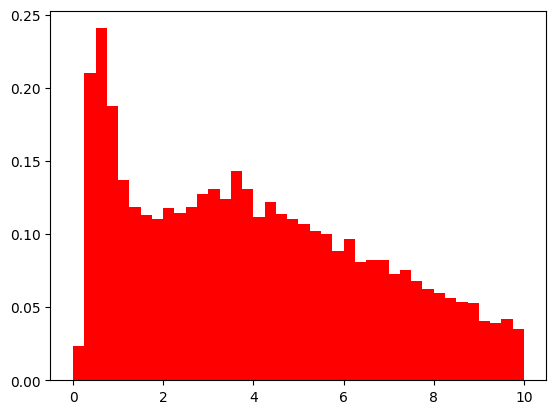

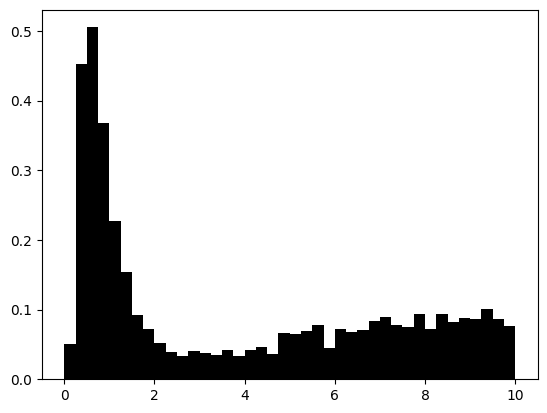

(array([0.09601082, 0.84651792, 0.94523327, 0.68018932, 0.41649763,
        0.27045301, 0.15415822, 0.10412441, 0.06896552, 0.04462475,
        0.0270453 , 0.0311021 , 0.01487492, 0.00811359, 0.01487492,
        0.00811359, 0.0040568 , 0.01081812, 0.00946586, 0.0040568 ,
        0.01081812, 0.0040568 , 0.00946586, 0.00811359, 0.01217039,
        0.01217039, 0.00676133, 0.00540906, 0.01217039, 0.00946586,
        0.00676133, 0.01622718, 0.01217039, 0.01352265, 0.01757945,
        0.01487492, 0.01352265, 0.01757945, 0.01217039, 0.02569304]),
 array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
         2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
         4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
         6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,
         9.  ,  9.25,  9.5 ,  9.75, 10.  ]),
 <BarContainer object of 40 artists>)

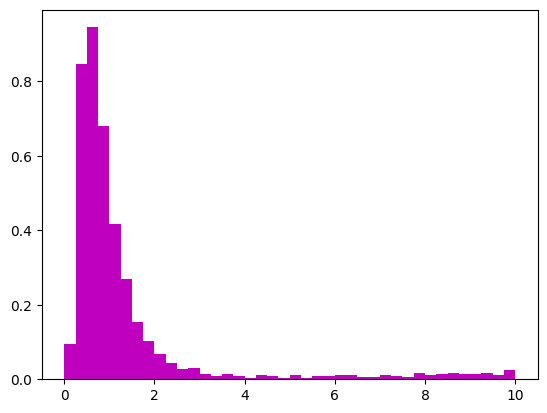

In [5]:
zlens, zsource = 0.5, 2.0
mass_ranges = [[6.0, 7.5], [7.5, 8.5], [8.5, 10.0]]

cdm_realization = CDM(zlens, zsource,sigma_sub=0.1,LOS_normalization=1.0)
ext = RealizationExtensions(cdm_realization)

log10_subhalo_time_scaling = -0.5
sigma_eff = [0, 0, 0.0]
cdm_realization0 = ext.toSIDM_from_cross_section(mass_ranges, sigma_eff, log10_subhalo_time_scaling)

sigma_eff = [2.7,2.3,1.5]
log10_subhalo_time_scaling = 0.5
sidm_realization1 = ext.toSIDM_from_cross_section(mass_ranges, sigma_eff, log10_subhalo_time_scaling)

log10_subhalo_time_scaling = 1.0
sidm_realization2 = ext.toSIDM_from_cross_section(mass_ranges, sigma_eff, log10_subhalo_time_scaling)

log10_subhalo_time_scaling = 1.5
sidm_realization3 = ext.toSIDM_from_cross_section(mass_ranges, sigma_eff, log10_subhalo_time_scaling)

t = []
for halo in sidm_realization1.halos:
    if halo.mdef == 'TNFW': continue
    t.append(halo.t_over_tc)
plt.hist(t, color='r',density=True, bins=40,range=(0, 10))
plt.show()
t = []
for halo in sidm_realization2.halos:
    if halo.mdef == 'TNFW': continue
    t.append(halo.t_over_tc)
plt.hist(t, color='k',density=True, bins=40,range=(0, 10))
plt.show()
t = []
for halo in sidm_realization3.halos:
    if halo.mdef == 'TNFW': continue
    t.append(halo.t_over_tc)
plt.hist(t, color='m',density=True, bins=40,range=(0, 10))

In [6]:
npix = 150 
grid_resolution_critcurves = 0.04
grid_size = 1.5
_x = _y = np.linspace(-grid_size, grid_size, npix)
xx, yy = np.meshgrid(_x, _y)
shape0 = xx.shape

# power law plus shear macromodel
kwargs_macromodel = [{'theta_E': 1., 'center_x': 0., 'center_y': 0., 'e1': 0.2, 'e2': -0.1, 'gamma': 2.},
                    {'gamma1': -0.03, 'gamma2': 0.02}]
lens_model_list_macro = ['EPL', 'SHEAR']
lens_model_macro = LensModel(lens_model_list_macro)

residual_kappa_map_list = []
ra_crit_list_list = []
dec_crit_list_list = []

for sidm_realization in [cdm_realization0, sidm_realization1, sidm_realization2, sidm_realization3]:
    print(sidm_realization)
    
    lens_model_list, lens_redshift_array, kwargs_halos, _ = sidm_realization.lensing_quantities()

    astropy_instance = sidm_realization.astropy_instance

    lens_model_list_full = lens_model_list_macro + lens_model_list
    lens_redshift_list_full = [zlens, zlens] + list(lens_redshift_array)
    kwargs_lens_full = kwargs_macromodel + kwargs_halos

    lens_model_full = LensModel(lens_model_list_full, zlens, zsource, 
                            lens_redshift_list_full, cosmo=astropy_instance, multi_plane=True)


    kappa_full = lens_model_full.kappa(xx.ravel(), yy.ravel(), kwargs_lens_full).reshape(shape0)
    kappa_macro = lens_model_macro.kappa(xx.ravel(), yy.ravel(), kwargs_macromodel).reshape(shape0)
    residual_kappa_map_list.append(kappa_full - kappa_macro)

    lens_model_extension = LensModelExtensions(lens_model_full)
    
    ra_crit_list, dec_crit_list, _, _ = lens_model_extension.critical_curve_caustics(kwargs_lens_full, 
                                                                compute_window=2*grid_size, 
                                                                grid_scale=grid_resolution_critcurves)
    ra_crit_list_list.append(ra_crit_list)
    dec_crit_list_list.append(dec_crit_list)


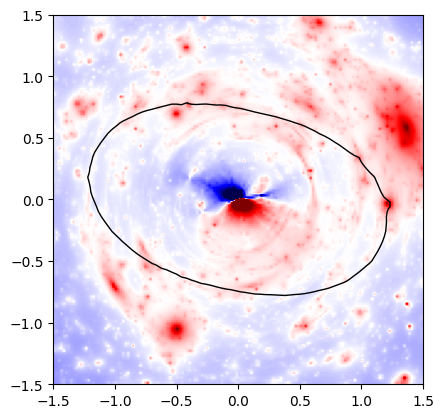

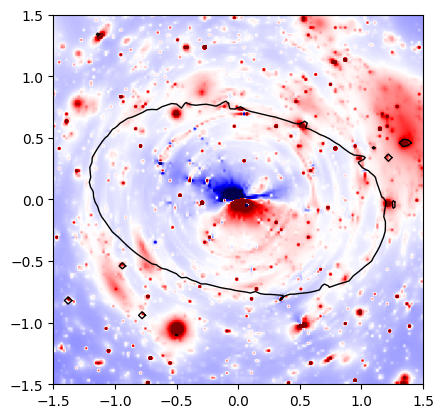

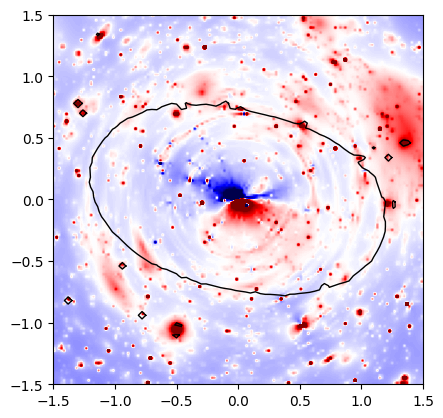

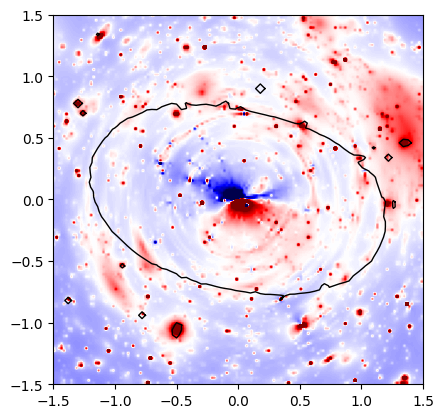

In [7]:
for (kap, rac, dec) in zip(residual_kappa_map_list, ra_crit_list_list, dec_crit_list_list):
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.imshow(kap-np.mean(kap), vmin=-0.1, vmax=0.1, cmap='seismic',
             extent=[-grid_size, grid_size, -grid_size, grid_size], origin='lower')
    for i in range(0, len(rac)):
        ax.plot(rac[i], dec[i], color='k', lw=1)
    plt.show()